# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

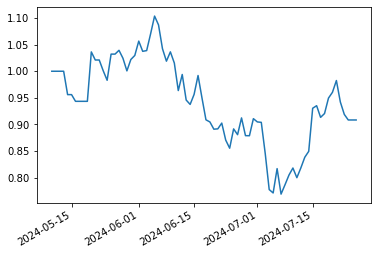

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT',
       'WBETHUSDT', 'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.400000
OMUSDT,0.376350
PEPEUSDT,0.083967
JASMYUSDT,0.071765
BNBUSDT,0.067918


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.488222
BTCUSDT,0.400000
JASMYUSDT,0.111778


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,725.183793,3.312815e-01,0.400000,-0.068719
JASMYUSDT,375.087881,1.713492e-01,0.111778,0.059571
SOLUSDT,267.892245,1.223797e-01,0.000000,0.000000
OMUSDT,252.047897,1.151416e-01,0.488222,-0.373080
ETHUSDT,227.388560,1.038766e-01,0.000000,0.000000
BBUSDT,138.795552,6.340517e-02,0.000000,0.000000
MKRUSDT,122.073743,5.576624e-02,0.000000,0.000000
BNBUSDT,59.086393,2.699209e-02,0.000000,0.000000
TRXUSDT,21.469867,9.807955e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.323328e-09,0.000000,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,725.183793,3.312815e-01,0.400000,-0.068719
JASMYUSDT,375.087881,1.713492e-01,0.071765,0.099584
SOLUSDT,267.892245,1.223797e-01,0.000000,0.000000
OMUSDT,252.047897,1.151416e-01,0.376350,-0.261208
ETHUSDT,227.388560,1.038766e-01,0.000000,0.000000
BBUSDT,138.795552,6.340517e-02,0.000000,0.000000
MKRUSDT,122.073743,5.576624e-02,0.000000,0.000000
BNBUSDT,59.086393,2.699209e-02,0.067918,-0.040926
TRXUSDT,21.469867,9.807955e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.323328e-09,0.083967,-0.083967


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

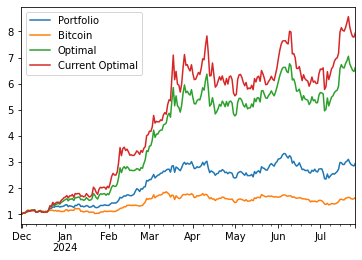

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

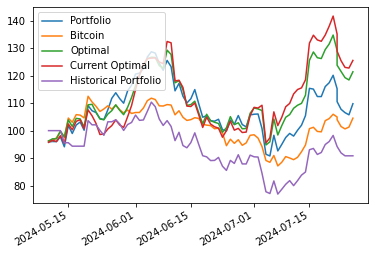

In [35]:
((1+current_perf).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.680355
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.558201
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.518325
Bitcoin            0.436404
Optimal            0.681722
Current Optimal    0.778126
dtype: float64

In [39]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.009709,0.015604,0.022698,0.002511,0.020186
BTCUSDT,0.029106,0.066669,0.176804,0.065567,0.111238
JASMYUSDT,0.018782,0.024148,0.052638,0.014573,0.038065
OMUSDT,0.906520,0.852827,0.661592,0.558879,0.102713
PEPEUSDT,0.035882,0.040752,0.086268,0.028310,0.057959


In [40]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.138450,0.306563,0.189807,0.047932,0.141876
JASMYUSDT,0.422077,0.200843,0.280378,0.112856,0.167522
SOLUSDT,0.133371,0.121636,0.123799,0.022165,0.101634
OMUSDT,0.445582,0.159837,0.134535,0.039273,0.095262
ETHUSDT,0.051223,0.094032,0.072612,0.008418,0.064194
BBUSDT,-0.163299,0.032678,0.124846,0.032526,0.092320
MKRUSDT,-0.023556,0.049776,0.053166,0.005523,0.047644
BNBUSDT,-0.009991,0.025107,0.019327,0.000603,0.018724
TRXUSDT,0.006143,0.009528,0.001528,0.000017,0.001511


## Value At Risk

### Historical

In [41]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05598024452379531, -0.08255584141253369)

In [42]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.046717354015027274, -0.06794585297308431)

### Parametric

In [43]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07063730952626639, -0.0905375006782321)

In [44]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.057838624193342694, -0.07413312472193702)

### Multivariate

In [45]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06275141452471944, -0.0812572906948902)

In [46]:
multivariate_distrib=current_risk.multivariate_distribution()
perf=performance(multivariate_distrib,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.056156438407207236, -0.07048059578467457)

In [47]:
multivariate_distrib=pd.DataFrame(multivariate_distrib,columns=current_risk.returns.columns)
multivariate_distrib=multivariate_distrib*current_weights
multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

BTCUSDT     -0.010771
JASMYUSDT   -0.028178
SOLUSDT     -0.010476
OMUSDT      -0.002242
ETHUSDT     -0.000753
BBUSDT      -0.000299
MKRUSDT     -0.001828
BNBUSDT     -0.001725
TRXUSDT      0.000118
Portfolio   -0.056153
Name: 3777, dtype: float64

### Copulas

In [48]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06133877104881904, -0.0800796483898864)

In [49]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054496927396362096, -0.06892176188125064)

In [50]:
gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

gaussian_copula_distrib=gaussian_copula_distrib*current_weights
gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]

BTCUSDT     -0.008600
JASMYUSDT   -0.009974
SOLUSDT     -0.010319
OMUSDT      -0.022783
ETHUSDT      0.000223
BBUSDT      -0.001248
MKRUSDT     -0.001788
BNBUSDT     -0.000593
TRXUSDT     -0.000307
Portfolio   -0.055390
Name: 3850, dtype: float64

In [51]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06264855345768496, -0.08121607939166502)

In [52]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058271837261842284, -0.07473168548894576)

In [53]:
t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
t_copula_distrib=t_copula_distrib*current_weights
t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]

BTCUSDT     -0.012933
JASMYUSDT   -0.027143
SOLUSDT     -0.009317
OMUSDT       0.002310
ETHUSDT     -0.000955
BBUSDT      -0.005058
MKRUSDT     -0.001710
BNBUSDT     -0.000541
TRXUSDT      0.000028
Portfolio   -0.055320
Name: 7141, dtype: float64

### Monte Carlo

In [54]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [55]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07311742173544443, -0.09063251959182012)

In [56]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05890952293863316, -0.07396118094271102)

In [57]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]/monte_carlo_var

BTCUSDT      0.234251
JASMYUSDT    0.015698
SOLUSDT      0.257285
OMUSDT       0.116188
ETHUSDT      0.068511
BBUSDT       0.181391
MKRUSDT      0.120409
BNBUSDT      0.004907
TRXUSDT      0.001359
Portfolio    1.000000
Name: 5857, dtype: float64

### VaR Violation

In [58]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058651,-0.094607,-0.082351,-0.025549
2024-01-15,-0.058651,-0.094633,-0.080162,0.017778
2024-01-16,-0.058651,-0.095066,-0.078223,0.049710
2024-01-17,-0.058651,-0.097044,-0.084548,-0.031632
2024-01-18,-0.058651,-0.099137,-0.087011,-0.035060
...,...,...,...,...
2024-07-22,-0.099091,-0.096443,-0.086528,-0.041514
2024-07-23,-0.099091,-0.095620,-0.087464,-0.018382
2024-07-24,-0.099091,-0.096257,-0.087160,-0.018465
2024-07-25,-0.099091,-0.095393,-0.086267,-0.007141


In [59]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036105,-0.091680,-0.082583,-0.018708
2024-05-29,-0.029028,-0.088187,-0.074162,-0.014951
2024-05-30,-0.029028,-0.077946,-0.069888,0.040841
2024-05-31,-0.027608,-0.074261,-0.062396,0.017700
2024-06-01,-0.027608,-0.074694,-0.061520,0.034950
2024-06-02,-0.027608,-0.074883,-0.063151,0.002785
2024-06-03,-0.019984,-0.070334,-0.056194,0.013359
2024-06-04,-0.019984,-0.053262,-0.042664,0.034710
2024-06-05,-0.019984,-0.050288,-0.036654,0.015043
2024-06-06,-0.019984,-0.049967,-0.037973,-0.003782


<AxesSubplot:>

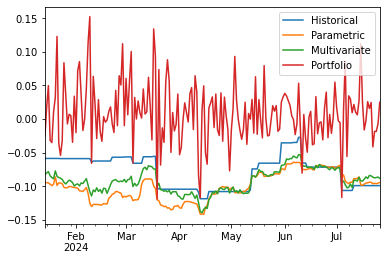

In [60]:
var_data.plot()

<AxesSubplot:>

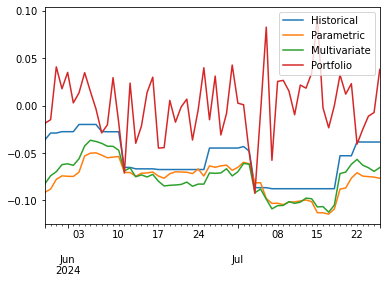

In [61]:
current_var_data.plot()

In [62]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020513,0.010256,0.015385
Kupiec Stat,4.548873,9.483315,6.671087
P-value,0.03294,0.002073,0.009799


In [63]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.083333,0.033333,0.033333
Kupiec Stat,1.179267,0.395582,0.395582
P-value,0.277505,0.52938,0.52938


## Principal Component Analysis

In [64]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76401611, 0.07498019, 0.06242848, 0.05427992, 0.04429531])

In [65]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61660682, 0.16592934, 0.09605092, 0.07802734, 0.04338558])

In [66]:
"""faire contrib a la var de chaques modeles"""

'faire contrib a la var de chaques modeles'

In [67]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

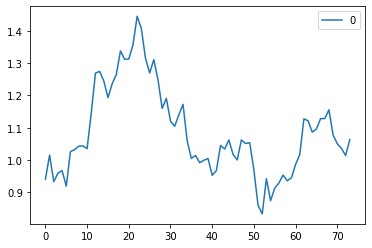

In [68]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

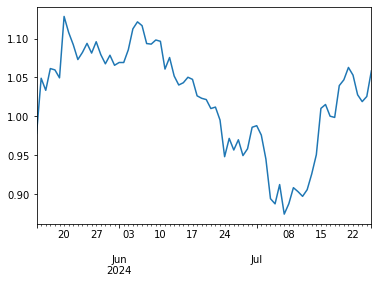

In [69]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()